In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
import pickle

from sklearn.ensemble import StackingRegressor

In [4]:
df = pd.read_csv("asuntojen_hintatiedot_postinumeroilla.csv")

train, test = train_test_split(df[["Postinumero", "Kaupunginosa", "Kaupunki", 	"Huoneisto", "Huoneistotyyppi",	"Talotyyppi",	"m2", "Velaton hinta"	,"Rakennusvuosi",	"Kerros"	,"Hissi"	,"Kunto"	,"Tontti"	,"Energialuokka"]], test_size=0.2, train_size=0.8, random_state=2022, shuffle=True, stratify = df["Talotyyppi"])

X_train, y_train = train.drop("Velaton hinta", axis = 1), train["Velaton hinta"]
X_test, y_test = test.drop("Velaton hinta", axis = 1), test["Velaton hinta"]

In [5]:
from JR_preprocess import MyCategoricalTransformer
from mrunsten_feature_extraction import FeatureExtraction
import mrunsten_feature_extraction
from Elias_wrappedRandomForestRegressor import WrappedModelRFR

In [6]:
model1 = pickle.load(open('MP_MR.mod', 'rb'))

model1.score(X_test, y_test)

0.8907802568656519

In [7]:
model2 = pickle.load(open('RandomForest_JR_finalized_model.mod', 'rb'))

model2.score(X_test, y_test)

0.8400441484371378

In [8]:
model3 = pickle.load(open('GB_MR.mod', 'rb'))

model3.score(X_test, y_test)

0.8608833876569127

In [9]:
model4 = pickle.load(open('CatBoost_JR.mod', 'rb'))

model4.score(X_test, y_test)

0.8586565823281375

In [10]:
model5 = pickle.load(open('GB_JR.mod', 'rb'))

model5.score(X_test, y_test)

0.8407985857089598

In [11]:
stack = StackingRegressor([
    ('MP_MR' ,model1),
    ('GB_JR' ,model5),
    ('GB_MR' ,model3),
    ('CatBoost_JR' ,model4),
    ],
    cv = "prefit",
    n_jobs = -1,
    final_estimator=MLPRegressor()
                         )

In [12]:
stack.fit(X_train, y_train)

StackingRegressor(cv='prefit',
                  estimators=[('MP_MR',
                               Pipeline(steps=[('data_preprocessing',
                                                ColumnTransformer(transformers=[('cat_cols',
                                                                                 Pipeline(steps=[('feature_extraction',
                                                                                                  FeatureExtraction()),
                                                                                                 ('imputer',
                                                                                                  SimpleImputer(fill_value='Tuntematon',
                                                                                                                strategy='constant')),
                                                                                                 ('onehot',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['Kaupunki',
                                                                                  'Huoneistotyyppi',
                                                                                  'Talo...
                                                                                  'Talotyyppi',
                                                                                  'm2',
                                                                                  'Rakennusvuosi',
                                                                                  'Kerros',
                                                                                  'Hissi',
                                                                                  'Kunto',
                                                                                  'Tontti',
                                                                                  'Energialuokka'])])),
                                               ('ohe',
                                                ColumnTransformer(n_jobs=-1,
                                                                  remainder='passthrough',
                                                                  transformers=[('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                               sparse=False),
                                                                                 [0])])),
                                               ('cat',
                                                <catboost.core.CatBoostRegressor object at 0x000001B2FCC9B1C0>)]))],
                  final_estimator=MLPRegressor(), n_jobs=-1)

In [13]:
stack.score(X_test, y_test)

0.8967571861583673

## Helsinki

In [14]:
def data_split_kaupunki(df, kaupunki):

    train, test = train_test_split(df[["Postinumero", "Kaupunginosa", "Kaupunki", 	"Huoneisto", "Huoneistotyyppi",	"Talotyyppi",	"m2", "Velaton hinta"	,"Rakennusvuosi",	"Kerros"	,"Hissi"	,"Kunto"	,"Tontti"	,"Energialuokka"]], test_size=0.2, train_size=0.8, random_state=2022, shuffle=True, stratify = df["Talotyyppi"])
    test = test[test["Kaupunki"] == kaupunki]
    X_test, y_test = test.drop("Velaton hinta", axis = 1), test["Velaton hinta"]

    print(f"R^2 kaupungilla {kaupunki}: {stack.score(X_test, y_test)}")

In [15]:
for kaupunki in ["Helsinki", "Oulu", "Tampere", "Turku", "Jyväskylä"]:
    data_split_kaupunki(df, kaupunki)

R^2 kaupungilla Helsinki: 0.8959218896208461
R^2 kaupungilla Oulu: 0.857535565469949
R^2 kaupungilla Tampere: 0.8645298081660788
R^2 kaupungilla Turku: 0.826311449061804
R^2 kaupungilla Jyväskylä: 0.8859741318462561


## Halvat/kalliit asunnot

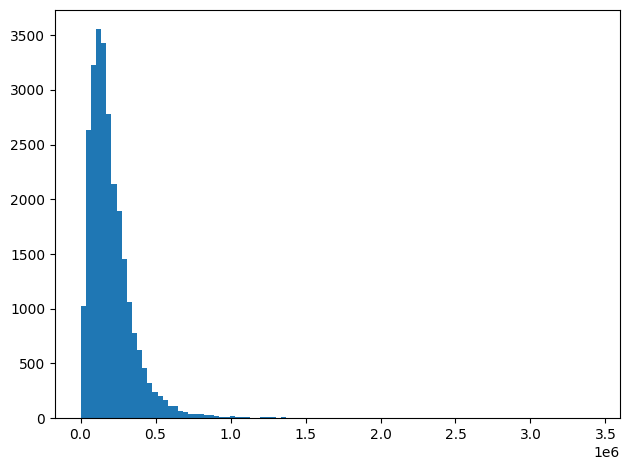

In [16]:
plt.hist(df["Velaton hinta"], bins = 100)
plt.tight_layout()

In [17]:
def data_split_quantiles(df, quantile_low, quantile_high):

    train, test = train_test_split(df[["Postinumero", "Kaupunginosa", "Kaupunki", 	"Huoneisto", "Huoneistotyyppi",	"Talotyyppi",	"m2", "Velaton hinta"	,"Rakennusvuosi",	"Kerros"	,"Hissi"	,"Kunto"	,"Tontti"	,"Energialuokka"]], test_size=0.2, train_size=0.8, random_state=2022, shuffle=True, stratify = df["Talotyyppi"])
    quantile_value_low = test["Velaton hinta"].quantile(quantile_low)
    quantile_value_high = test["Velaton hinta"].quantile(quantile_high)
    test = test[(test["Velaton hinta"] > quantile_value_low) & (test["Velaton hinta"] < quantile_value_high)]
    X_test, y_test = test.drop("Velaton hinta", axis = 1), test["Velaton hinta"]

    print(f"R^2 kvantiililla {quantile_low, quantile_high}: {stack.score(X_test, y_test)}")

In [18]:
for quantile_low, quantile_high in zip([0, 0.15, 0.25, 0.4, 0.65, 0.8],[0.15, 0.25, 0.4, 0.65, 0.8, 0.95]):
    data_split_quantiles(df, quantile_low, quantile_high)
    #print(quantile_low, quantile_high)

R^2 kvantiililla (0, 0.15): -2.0440481352929702
R^2 kvantiililla (0.15, 0.25): -15.293074344647188
R^2 kvantiililla (0.25, 0.4): -5.486294177916131
R^2 kvantiililla (0.4, 0.65): -1.108489643555298
R^2 kvantiililla (0.65, 0.8): -2.27827721504674
R^2 kvantiililla (0.8, 0.95): -0.1297247658233276


In [19]:
def data_split_huoneet(df, huone1, huone2):
    train, test = train_test_split(df[["Postinumero", "Kaupunginosa", "Kaupunki", 	"Huoneisto", "Huoneistotyyppi",	"Talotyyppi",	"m2", "Velaton hinta"	,"Rakennusvuosi",	"Kerros"	,"Hissi"	,"Kunto"	,"Tontti"	,"Energialuokka"]], test_size=0.2, train_size=0.8, random_state=2022, shuffle=True, stratify = df["Talotyyppi"])
    test = test[test["Huoneistotyyppi"] == (huone1 or huone2)]
    X_test, y_test = test.drop("Velaton hinta", axis = 1), test["Velaton hinta"]
    print(f"R^2 huoneilla {huone1 , huone2}: {stack.score(X_test, y_test)}")

In [20]:
for huone1, huone2 in zip(["Yksiö", "Kolme huonetta"], ["Kaksi huonetta", "Neljä huonetta tai enemmän"]):
    data_split_huoneet(df, huone1, huone2)

R^2 huoneilla ('Yksiö', 'Kaksi huonetta'): 0.9243761916491479
R^2 huoneilla ('Kolme huonetta', 'Neljä huonetta tai enemmän'): 0.9164001142966105
